In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

X, y = make_classification(n_samples=1000, n_features=15, n_informative=10, n_redundant=2, n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

df = pd.DataFrame(X, columns=[f'Fitur_{i}' for i in range(1, 16)])
df['Target'] = y

df['Fitur_12'] = np.random.choice(['A', 'B', 'C'], size=1000)
df['Fitur_13'] = np.random.choice(['X', 'Y', 'Z'], size=1000)

X = df.drop('Target', axis=1)
y = df['Target']

print("Distribusi kelas sebelum SMOTE: ", Counter(y))

#feature selection using embeded methods

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_integer = X.drop(['Fitur_12', 'Fitur_13'], axis=1)
rf_model.fit(X_integer, y)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

threshold = 0.05
important_features_indices = [i for i in range(len(importances)) if importances[i] > threshold]

print("Fitur yang dipilih dengan embeded methods (diatas ambang batas): ")
for i in important_features_indices:
    print(f'{X.columns[i]} : {importances[i]}')

important_features = X_integer.columns[important_features_indices]

X_important = X_integer[important_features]

print("\nDimensi data pelatihan dengan fitur penting ", X_important.shape)

Distribusi kelas sebelum SMOTE:  Counter({0: 901, 1: 99})
Fitur yang dipilih dengan embeded methods (diatas ambang batas): 
Fitur_2 : 0.11860019897866204
Fitur_3 : 0.06878603593465268
Fitur_5 : 0.07730816635519337
Fitur_8 : 0.050581945407184616
Fitur_9 : 0.2623610396012453
Fitur_10 : 0.08958259568334653
Fitur_11 : 0.0637202500080853
Fitur_13 : 0.12579042301314702

Dimensi data pelatihan dengan fitur penting  (1000, 8)


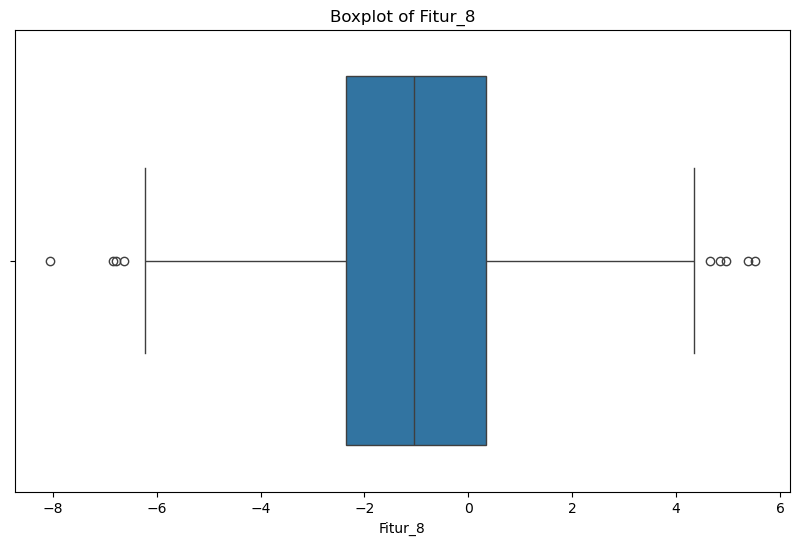

In [42]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

X_selected = pd.concat([X_important, X['Fitur_12']], axis=1)
X_selected = pd.concat([X_selected, X['Fitur_13']], axis=1)

label_encoder = LabelEncoder()

X_selected['Fitur_12'] = label_encoder.fit_transform(X_selected['Fitur_12'])
X_selected['Fitur_13'] = label_encoder.fit_transform(X_selected['Fitur_13'])

numeric_columns = X_selected.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['Fitur_12', 'Fitur_13'])
X_cleaned = X_important.copy()
y_cleaned = y.copy()

plt.figure(figsize=(10,6))
sns.boxplot(x=X_cleaned['Fitur_8'])
plt.title(f"Boxplot of Fitur_8")
plt.show()


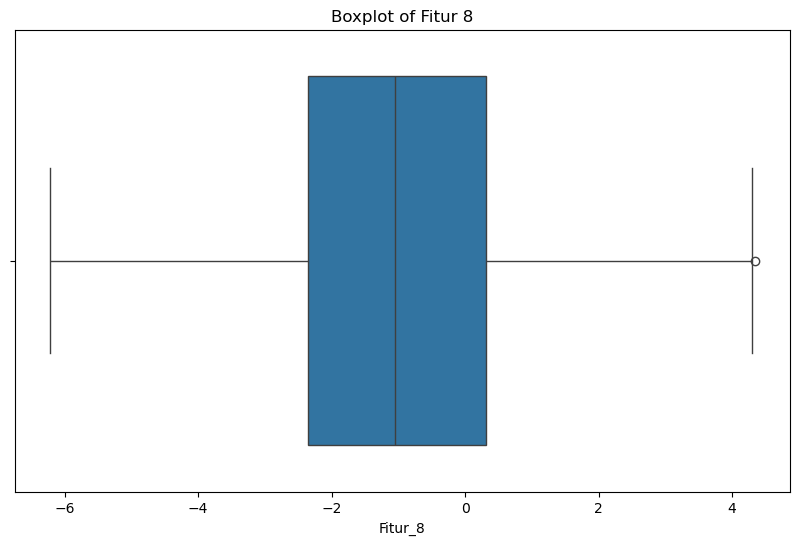

949

In [ ]:
for col in numeric_columns:
    Q1 = X_important[col].quantile(0.25)
    Q3 = X_important[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X_cleaned[(X_cleaned[col] < lower_bound) | (X_cleaned[col] > upper_bound)]

    X_cleaned = X_cleaned.drop(outliers.index)
    y_cleaned = y_cleaned.drop(outliers.index)

X_cleaned = X_cleaned.reset_index(drop=True)
y_cleaned = y_cleaned.reset_index(drop=True)    

plt.figure(figsize=(10,6))
sns.boxplot(x=X_cleaned['Fitur_8'])
plt.title('Boxplot of Fitur 8')
plt.show()

Distribusi kelas setelah SMOTE  Counter({0: 875, 1: 875})


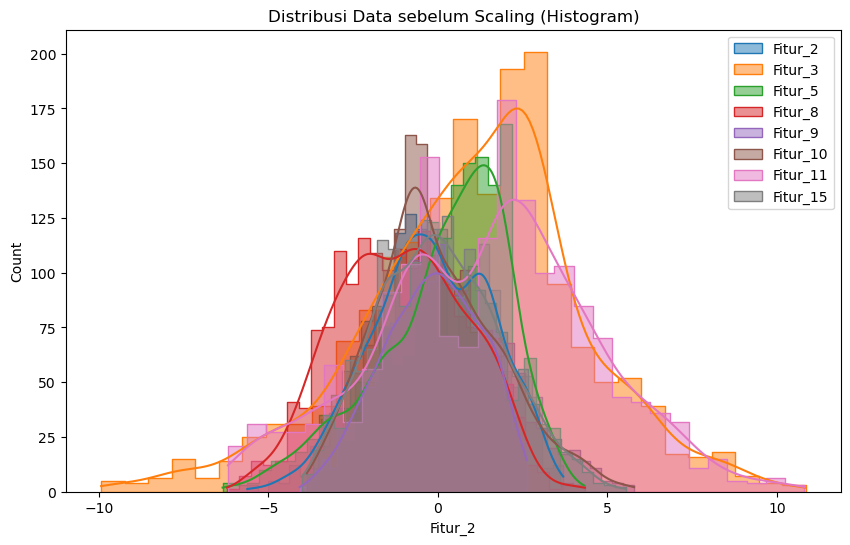

In [49]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

print("Distribusi kelas setelah SMOTE ", Counter(y_resampled))

X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled, name='Target')

plt.figure(figsize=(10, 6))

for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, bins=30, label=col, element='step')

plt.title('Distribusi Data sebelum Scaling (Histogram)')
plt.legend()
plt.show()

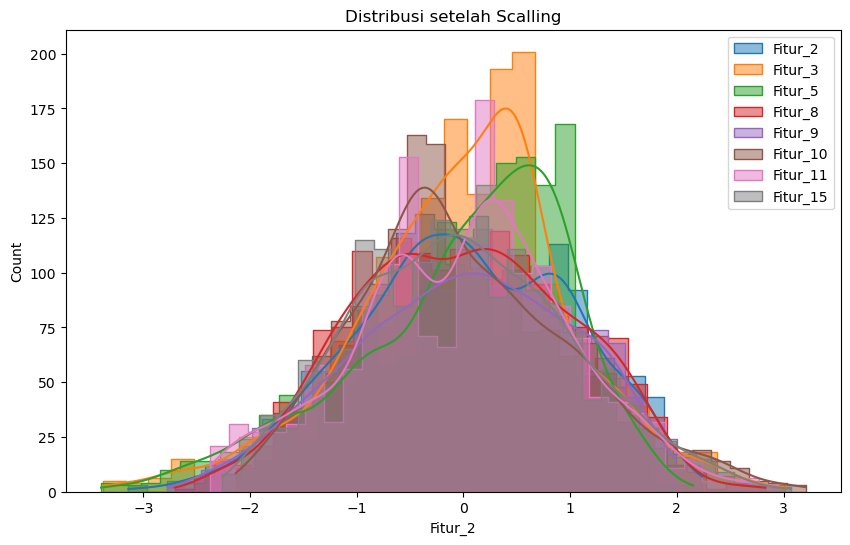

In [50]:
standard_scaler = StandardScaler()

X_resampled[important_features] = standard_scaler.fit_transform(X_resampled[important_features])

plt.figure(figsize=(10, 6))

for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')

plt.title('Distribusi setelah Scalling')
plt.legend()
plt.show()